---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**

----------------

## The Transportation Problem
### Integrating `pysal/spaghetti` and [python-mip](https://github.com/coin-or/python-mip) for optimal shipping

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook provides a use case for:**

1. Introducing the Transportation Problem
2. Declaration of a solution class and model parameters
3. Solving the Transportation Problem for an optimal shipment plan

In [1]:
%load_ext watermark
%watermark

2020-02-03T10:54:44-05:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


**In addtion to the base** **[spaghetti requirements](https://github.com/pysal/spaghetti/blob/master/requirements.txt)** **(and their dependecies), this notebook requires installations of:**

* [geopandas](http://geopandas.org)
    * `$ conda install -c conda-forge geopandas`
* [matplotlib](https://matplotlib.org)
    * `$ conda install matplotlib`
* [pulp](https://anaconda.org/conda-forge/pulp)
    * `$ conda install -c conda-forge pulp`    

-----------------------

In [2]:
import spaghetti
import geopandas
from libpysal import examples
import matplotlib
import numpy
import mip
try:
    from IPython.display import set_matplotlib_formats

    set_matplotlib_formats("retina")
except ImportError:
    pass
%matplotlib inline
%watermark -w
%watermark -iv

Using Python-MIP package version 1.6.8
watermark 2.0.2
numpy      1.17.3
spaghetti  1.4.1
matplotlib 3.1.2
geopandas  0.6.2
mip        1.6.8



-----------------------------

### 1 Introduction
#### Scenario
The Transportation Problem, which is also known as the Transportation Simplex or the Transshipment Problem, seeks to allocate supply to demand while minimizing transportation costs and was formally described by Hitchcock (1941). Supply ($\textit{n}$) and demand ($\textit{m}$) are generally represented as unit weights of decision variables at facilities along a network with the time or distance between nodes representing the cost of transporting one unit from a supply node to a demand node. These costs are stored in an $\textit{n x m}$ cost matrix.

--------------------------------

#### Integer Linear Programming Formulation based on Daskin (2013, Ch. 2).

$\begin{array}
\displaystyle \normalsize \textrm{Minimize} & \displaystyle \normalsize \sum_{i \in I} \sum_{j \in J} c_{ij}x_{ij}  & & & &  \normalsize (1) \\
\normalsize \textrm{Subject To} & \displaystyle \normalsize \sum_{j \in J} x_{ij} \leq S_i & \normalsize \forall i \in I; &  & &\normalsize (2)\\
 & \displaystyle \normalsize \sum_{i \in I} x_{ij} \geq D_j & \normalsize \forall j \in J; &  & &\normalsize (3)\\
& \displaystyle \normalsize x_{ij} \geq 0 & \displaystyle \normalsize \forall i \in I & \displaystyle \normalsize \normalsize \forall j \in j. & &\normalsize (4)\\
\end{array}$

$\begin{array}
\displaystyle \normalsize \textrm{Where} & \small i & \small = & \small \textrm{each potential origin node} &&&&\\
& \small I & \small = & \small \textrm{the complete set of potential origin nodes} &&&&\\
& \small j & \small = & \small \textrm{each potential destination node} &&&&\\
& \small J & \small = & \small \textrm{the complete set of potential destination nodes} &&&&\\
& \small x_{ij} & \small = & \small \textrm{amount to be shipped from } i \in I \textrm{ to } j \in J  &&&&\\
& \small c_{ij} & \small = & \small \textrm{per unit shipping costs between all } i,j \textrm{ pairs} &&&& \\
& \small S_i & \small = & \small \textrm{node } i \textrm{ supply for } i \in I &&&&\\
& \small D_j & \small = & \small \textrm{node } j \textrm{ demand for } j \in J &&&&\\
\end{array}$


---------------------------------

**References**

* **Church, Richard L. and Murray, Alan T.** (2009) *Business Site Selection, Locational Analysis, and GIS*. Hoboken. John Wiley & Sons, Inc.

* **Daskin, M.** (2013) *Network and Discrete Location: Models, Algorithms, and Applications*. New York: John Wiley & Sons, Inc.

* **Gass, S. I. and Assad, A. A.** (2005) *An Annotated Timeline of Operations Research: An Informal History*. Springer US.

* **Hitchcock, Frank L.** (1941) *The Distribution of a Product from Several Sources to Numerous Localities*. Journal of Mathematics and Physics. 20(1):224-230.

* **Koopmans, Tjalling C.** (1949) *Optimum Utilization of the Transportation System*. Econometrica. 17:136-146.

* **Miller, H. J. and Shaw, S.-L.** (2001) *Geographic Information Systems for Transportation: Principles and Applications*. New York. Oxford University Press.


* **Phillips, Don T. and Garcia‐Diaz, Alberto.** (1981) *Fundamentals of Network Analysis*. Englewood Cliffs. Prentice Hall. 

-----------------

@book{Church2009,
address = {Hoboken},
author = {Church, Richard L. and Murray, Alan T.},
publisher = {John Wiley {\&} Sons, Inc.},
title = {{Business Site Selection, Locational Analysis, and GIS}},
year = {2009}
}



@article{Koopmans1949,
author = {Koopmans, Tjalling},
journal = {Econometrica},
pages = {136--146},
title = {{Optimum Utilization of the Transportation System}},
volume = {17},
year = {1949}
}


@book{Phillips1981a,
address = {Englewood Cliffs, NJ},
author = {Phillips, Don T. and Garcia‐Diaz, Alberto},
publisher = {Prentice Hall},
title = {{Fundamentals of Network Analysis}},
year = {1981}
}


------------------




-------------------------------------

### 2. A model, data and parameters
#### Solution class

In [3]:
class TransportationProblem:
    def __init__(self, nodes, cij, xij_tag="x_%s,%s", si_tag="s_%s", dj_tag="d_%s"):
        """Instantiate and solve the Primal Transportation Problem
        based the formulation from Daskin (2013, Ch. 2).
        
        Parameters
        ----------
        nodes : geopandas.GeoSeries
            All nodes to be visited in the tour.
        cij : numpy.array
            All-to-all distance matrix for nodes.
        xij_tag : str
            Tour decision variable names within the model. Default is
            'x_%s,%s' where %s indicates string formatting.
        si_tag : str
            Supply capacity from location 'i'.
            Default is 's_%s' where %s indicates string formatting.
        dj_tag : str
            Demand capacity from location 'j'.
            Default is 'd_%s' where %s indicates string formatting.
        
        Attributes
        ----------
        nodes : geopandas.GeoSeries
            See description in above.
        p : int
            The number of nodes in the set.   
        rp_0n : range
            Range of node IDs in ``nodes`` from 0,...,``p``.
        rp_1n : range
            Range of node IDs in ``nodes`` from 1,...,``p``.
        id : str
            Column name for ``nodes``.
        cij : numpy.array
            See description in above.
        xij_tag : str
            See description in above.
        si_tag : str
            See description in above.
        dj_tag : str
            See description in above.
        trans_prob : pulp.LpProblem
            Integer Linear Programming problem instance.
        xij : numpy.array
            Binary tour decision variables (``pulp.LpVariable``).
        si : numpy.array
            Continuous arbitrary real number decision variables
            (``pulp.LpVariable``).
        
        
        cycle_ods : dict
            Cycle origin-destination lookup keyed by origin with
            destination as the value.
        tour_pairs : list
            OD pairs comprising each abstract tour arc.
        """

        # all nodes to be visited and the distance matrix
        self.nodes, self.cij = nodes, cij
        # number of nodes in the set
        self.p = self.nodes.shape[0]
        # full and truncated range of nodes (p) in the set
        self.rp_0n, self.rp_1n = range(self.p), range(1, self.p)
        # column name for node IDs
        self.id = self.nodes.name
        # alpha tag for decision and dummy variable prefixes
        self.xij_tag, self.ui_tag = xij_tag, ui_tag

        # instantiate a model
        self.trans_prob = pulp.LpProblem("Transportation Problem", pulp.LpMinimize)
        # create and set the tour decision variables
        self.tour_dvs()
        # create and set the arbitraty real number decision variables
        self.arn_dvs()
        # set the objective function
        self.objective_func()
        # node entry constraints
        self.entry_exit_constrs(entry=True)
        # node exit constraints
        self.entry_exit_constrs(entry=False)
        # subtour prevention constraints
        self.prevent_subtours()
        # solve
        self.tsp.solve()
        # origin-destination lookup
        self.get_decisions(display=display)
        # extract the sequence of nodes to construct the optimal tour
        self.construct_tour()

    def shipping_dvs(self):
        """Create the shipping decision variables - eq (4)."""

        def _name(_x):
            """Helper for naming variables"""
            return self.nodes[_x].split("_")[-1]

        xij = numpy.array(
            [
                [
                    pulp.LpVariable(self.xij_tag % (_name(i), _name(j)), cat="Binary")
                    for j in self.rp_0n
                ]
                for i in self.rp_0n
            ]
        )

        self.xij = xij

    def arn_dvs(self):
        """Create arbitrary real number decision variables - eq (6)."""
        ui = numpy.array(
            [pulp.LpVariable(self.ui_tag % (i), lowBound=0) for i in self.rp_0n]
        )

        self.ui = ui

    def objective_func(self):
        """Add the objective function - eq (1)."""
        self.tsp += pulp.lpSum(
            [
                self.cij[i, j] * self.xij[i, j]
                for i in self.rp_0n
                for j in self.rp_0n
                if i != j
            ]
        )

    def entry_exit_constrs(self, entry=True):
        """Add entry and exit constraints - eq (2) and (3)."""
        if entry:
            for i in self.rp_0n:
                self.tsp += (
                    pulp.lpSum([self.xij[i, j] for j in self.rp_0n if i != j]) == 1
                )
        # exit constraints
        else:
            for j in self.rp_0n:
                self.tsp += (
                    pulp.lpSum([self.xij[i, j] for i in self.rp_0n if i != j]) == 1
                )

    def prevent_subtours(self):
        """Add subtour prevention constraints - eq (4)."""
        for i in self.rp_1n:
            for j in self.rp_1n:
                if i != j:
                    self.tsp += (
                        self.ui[i] - self.ui[j] + self.p * self.xij[i, j] <= self.p - 1
                    )

    def get_decisions(self, display=True):
        """Fetch the selected decision variables."""
        cycle_ods = {}
        for var in self.tsp.variables():
            if var.name.startswith(self.ui_tag[0]):
                continue
            if var.varValue > 0:
                if display:
                    print("%s: %s" % (var.name, var.varValue))
                od = var.name.split("_")[-1]
                o, d = [int(tf) for tf in od.split(",")]
                cycle_ods[o] = d
        if display:
            print("Status: %s" % pulp.LpStatus[self.tsp.status])

        self.cycle_ods = cycle_ods

    def extract_shipments(self, paths, id_col, ship="leg"):
        """Extract the supply to demand shipments as a 
        ``geopandas.GeoDataFrame`` of ``shapely.geometry.LineString`` objects.
        
        Parameters
        ----------
        paths : geopandas.GeoDataFrame
            Shortest-path routes between all observations.
        id_col : str
            ID column name.
        leg_label : str
            Column name for the tour sequence. Default is 'leg'.
        
        Returns
        -------
        shipments : geopandas.GeoDataFrame
            Optimal tour of ``self.nodes`` squenced by ``leg_label``.
        """
        paths[leg_label] = int
        # set label of journey leg for each OD pair.
        for leg, cp in self.tour_pairs.items():
            paths.loc[(paths[id_col] == tuple(cp)), leg_label] = leg
        # extract only paths in the tour
        shipments = paths[paths[leg_label] != int].copy()
        shipments.sort_values(by=[leg_label], inplace=True)

        return tour

In [4]:
print(dir(mip))

['Any', 'BINARY', 'BranchSelector', 'CBC', 'CONTINUOUS', 'CPLEX', 'CPX', 'Column', 'ColumnsGenerator', 'Constr', 'ConstrList', 'ConstrsGenerator', 'CutPool', 'Dict', 'EPS', 'EQUAL', 'Enum', 'GRB', 'GREATER_OR_EQUAL', 'GUROBI', 'INF', 'INTEGER', 'IncumbentUpdater', 'InfeasibleSolution', 'InvalidLinExpr', 'InvalidParameter', 'LESS_OR_EQUAL', 'LP_Method', 'LinExpr', 'List', 'MAX', 'MAXIMIZE', 'MIN', 'MINIMIZE', 'Model', 'OptimizationStatus', 'Optional', 'ParameterNotAvailable', 'ProgressLog', 'SCIP', 'SearchEmphasis', 'Solver', 'TYPE_CHECKING', 'Tuple', 'Union', 'VConstrList', 'VERSION', 'VVarList', 'Var', 'VarList', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'callbacks', 'constants', 'customCbcLib', 'defaultdict', 'entities', 'environ', 'exceptions', 'isfile', 'lists', 'load_mipstart', 'log', 'maximize', 'minimize', 'model', 'name', 'out', 'quicksum', 'read_custom_settings', 'save_mipstart', 'solver

In [5]:
#cij = numpy.array([[3, 4, 5], [1, 1, 1], [5, 4, 3]])
cij = numpy.array([[2, 2, 2], [2, 2, 2], [2, 2, 2]])
cij

array([[2, 2, 2],
       [2, 2, 2],
       [2, 2, 2]])

In [41]:
#si = numpy.array([30, 40, 50])
si = numpy.array([10, 10, 10])
si

array([10, 10, 10])

In [42]:
#dj = numpy.array([[10], [70], [40]])
dj = numpy.array([10, 10, 10])
dj

array([10, 10, 10])

In [43]:
si.sum() == dj.sum()

True

In [44]:
si[0]

10

In [59]:
model = mip.Model("trans_prob", solver_name="cbc", sense=mip.MINIMIZE)
model

In [60]:
rows, cols = cij.shape[0], cij.shape[1]

xij = numpy.array([
    [model.add_var(
        "x_%s,%s" % (i,j), 
        var_type=mip.CONTINUOUS,
        lb=0,
        obj=cij[i,j]
    ) for j in range(cols)]
    for i in range(rows)
])
xij

In [61]:
mip.CONTINUOUS

'C'

In [62]:
xij = numpy.array([
    [model.add_var(
        "x_%s,%s" % (i,j), 
        var_type=mip.CONTINUOUS,
        lb=0,
        obj=cij[i,j]
    ) for j in range(cols)]
    for i in range(rows)
], dtype=mip.entities.Var)
xij

array([[<mip.entities.Var object at 0x11d062550>,
        <mip.entities.Var object at 0x11d062748>]], dtype=object)

In [63]:
xij[0,0].name, xij[0,0].lb, xij[0,0].ub, xij[0,0].obj

('x_0,0', 0.0, 1.7976931348623157e+308, 2.0)

In [64]:
xij[0,1].name, xij[0,1].lb, xij[0,1].ub, xij[0,1].obj

('x_0,1', 0.0, 1.7976931348623157e+308, 2.0)

In [65]:
model.objective = mip.minimize(
    mip.xsum(cij[i,j]*xij[i,j] for i in range(rows) for j in range(cols))
)

model.objective = mip.minimize(
    mip.xsum(cij[i,j]*xij[i,j] for i in range(rows) for j in range(cols))
)

In [66]:
# one per row
for i in range(rows):
    model += mip.xsum(xij[i,j] for j in range(cols)) <= si[i], 'supply({})'.format(i)
    print(si[i], [xij[i,j].obj for j in range(cols)])
    
# one per column
for j in range(cols):
    print(dj[j])
    model += mip.xsum(xij[i,j] for i in range(rows)) >= dj[j], 'demand({})'.format(j)

10 [2.0, 2.0, 2.0]
10 [2.0, 2.0, 2.0]
10 [2.0, 2.0, 2.0]
10
10
10


In [67]:
model.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [68]:
model.num_solutions

1

In [69]:
model.write("transportation.lp")

In [70]:
print(dir(xij[0,0]))

['_Var__model', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rsub__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', 'column', 'idx', 'lb', 'name', 'obj', 'rc', 'ub', 'var_type', 'x', 'xi']


In [71]:
for i in range(rows):
    for j in range(cols):
        print(xij[i][j], xij[i][j].x)

x_0,0 0.0
x_0,1 0.0
x_0,2 0.0
x_1,0 0.0
x_1,1 0.0
x_1,2 0.0
x_2,0 0.0
x_2,1 0.0
x_2,2 0.0


In [1]:
model.objective_values()

NameError: name 'model' is not defined

In [277]:
print(dir(model))

['_Model__clique', '_Model__cut_passes', '_Model__cuts', '_Model__cuts_generator', '_Model__gap', '_Model__infeas_tol', '_Model__integer_tol', '_Model__lazy_constrs_generator', '_Model__lp_method', '_Model__max_mip_gap', '_Model__max_mip_gap_abs', '_Model__n_cols', '_Model__n_rows', '_Model__opt_tol', '_Model__plog', '_Model__preprocess', '_Model__start', '_Model__store_search_progress_log', '_Model__threads', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_ownSolver', '_status', 'add_constr', 'add_cut', 'add_lazy_constr', 'add_sos', 'add_var', 'check_optimization_results', 'clear', 'clique', 'constr_by_name', 'constrs', 'copy', 'cut_passes', 'cutoff', 'cuts', 'cuts_gene

In [43]:
print(help(mip.Model))

Help on class Model in module mip.model:

class Model(builtins.object)
 |  Model(name: str = '', sense: str = 'MIN', solver_name: str = '', solver: Union[mip.solver.Solver, NoneType] = None)
 |  
 |  Mixed Integer Programming Model
 |  
 |  This is the main class, providing methods for building, optimizing,
 |  querying optimization results and re-optimizing Mixed-Integer Programming
 |  Models.
 |  
 |  To check how models are created please see the
 |  :ref:`examples <chapExamples>` included.
 |  
 |  Attributes:
 |      vars(VarList): list of problem variables (:class:`~mip.model.Var`)
 |      constrs(ConstrList): list of constraints (:class:`~mip.model.Constr`)
 |  
 |  Examples:
 |      >>> from mip import Model, MAXIMIZE, CBC, INTEGER, OptimizationStatus
 |      >>> model = Model(sense=MAXIMIZE, solver_name=CBC)
 |      >>> x = model.add_var(name='x', var_type=INTEGER, lb=0, ub=10)
 |      >>> y = model.add_var(name='y', var_type=INTEGER, lb=0, ub=10)
 |      >>> model += x + y <

In [77]:
cij = [[2, 2, 2], [2, 2, 2], [2, 2, 2]]
si = [10,10,10]
dj = [10,10,10]
model = mip.Model("trans_prob", solver_name="cbc", sense=mip.MINIMIZE)
rows, cols = len(si), len(dj)
xij = [
    [model.add_var(
        "x_%s,%s" % (i,j), 
        var_type=mip.CONTINUOUS,
        lb=0,
        obj=cij[i][j]
    ) for j in range(cols)]
    for i in range(rows)
]
model.objective = mip.minimize(
    mip.xsum(cij[i][j]*xij[i][j] for i in range(rows) for j in range(cols))
)
# one per row
for i in range(rows):
    model += mip.xsum(xij[i][j] for j in range(cols)) <= si[i], 'supply({})'.format(i) 
# one per column
for j in range(cols):
    model += mip.xsum(xij[i][j] for i in range(rows)) >= dj[j], 'demand({})'.format(j) 
model.optimize()
model.write("transportation.lp")
for i in range(rows):
    for j in range(cols):
        print(xij[i][j], xij[i][j].x)

x_0,0 0.0
x_0,1 10.0
x_0,2 0.0
x_1,0 0.0
x_1,1 0.0
x_1,2 10.0
x_2,0 10.0
x_2,1 0.0
x_2,2 0.0


In [210]:
from mip import Model, xsum, maximize, BINARY

p = [10, 13, 18, 31, 7, 15]
w = [11, 15, 20, 35, 10, 33]
c, I = 47, range(len(w))

m = Model('knapsack')

x = [m.add_var(var_type=BINARY) for i in I]

m.objective = maximize(xsum(p[i] * x[i] for i in I))

m += xsum(w[i] * x[i] for i in I) <= c

m.optimize()

selected = [i for i in I if x[i].x >= 0.99]
print('selected items: {}'.format(selected))

selected items: [0, 1, 2]


#### Streets

In [4]:
streets = geopandas.read_file(examples.get_path("streets.shp"))
streets.crs = "epsg:2223"
streets = streets.to_crs("epsg:2762")

#### Schools

In [5]:
schools = geopandas.read_file(examples.get_path("schools.shp"))
schools.crs = "epsg:2223"
schools = schools.to_crs("epsg:2762")

#### Schools - supply nodes

In [9]:
supply = schools[schools["POLYID"].isin([1,6,7,8])]
supply

,POLYID,geometry
0,1,POINT (221614.608 268182.322)
5,6,POINT (221542.156 268184.287)
6,7,POINT (221847.332 267982.491)
7,8,POINT (221406.289 267990.060)


#### Schools - demand nodes

In [15]:
demand = schools[schools["POLYID"].isin([2,3,4,5])]
demand

,POLYID,geometry
1,2,POINT (221121.722 268130.726)
2,3,POINT (221474.120 267187.725)
3,4,POINT (220452.594 268086.776)
4,5,POINT (221235.286 267684.289)


#### Instantiate a network object

In [16]:
ntw = spaghetti.Network(in_data=streets)
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

#### Plot

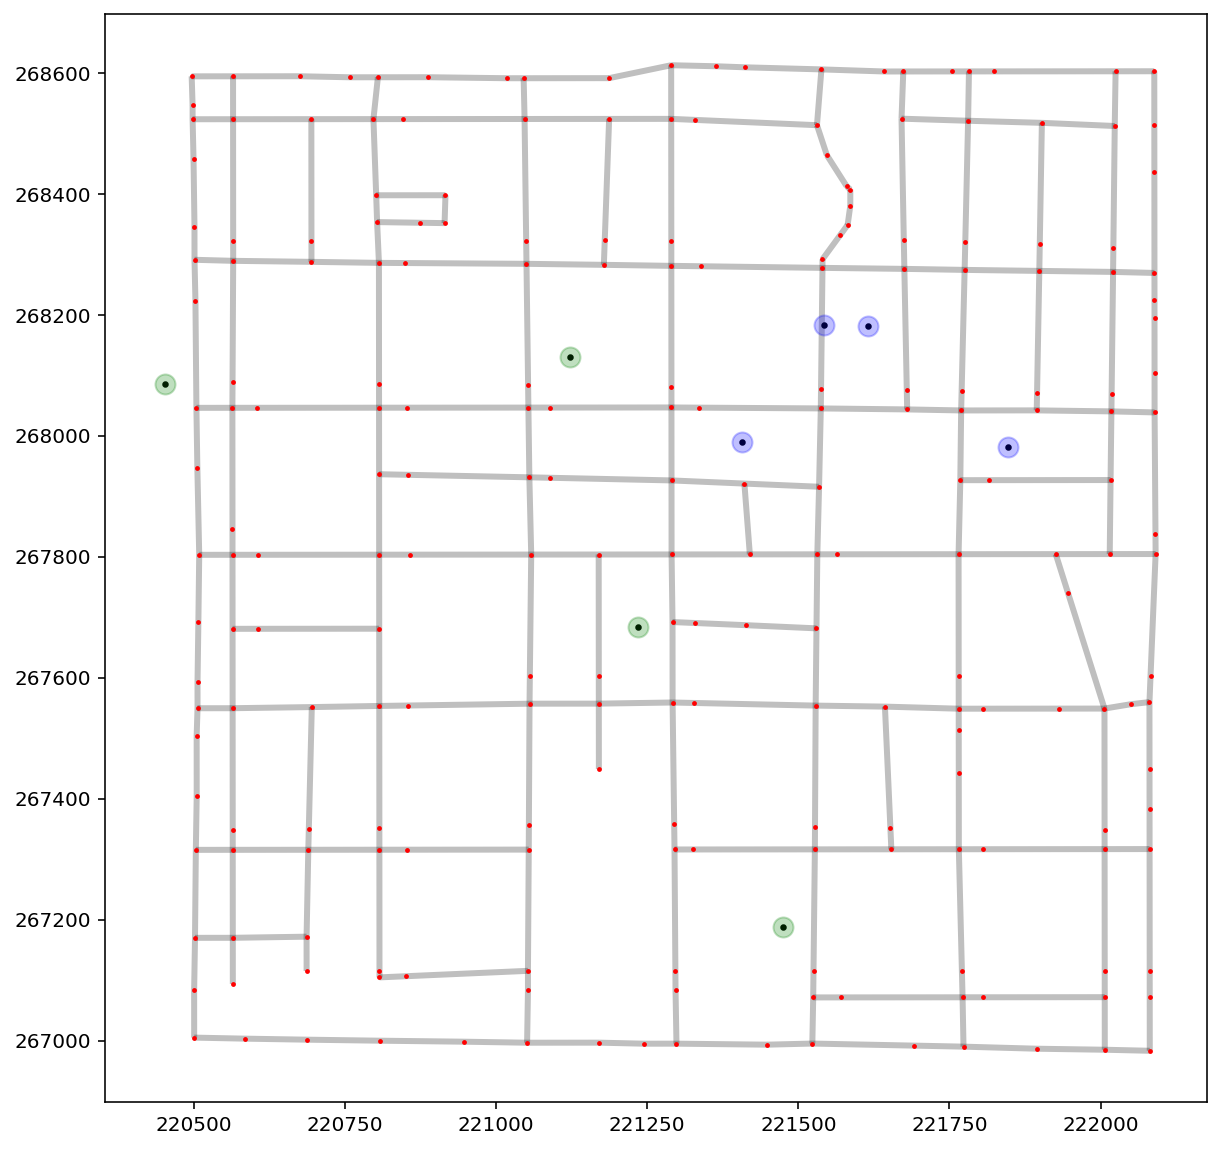

In [17]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=2, color="red", zorder=1)
schools.plot(ax=base, markersize=5, color="k", zorder=2)
supply.plot(ax=base, markersize=100, alpha=0.25, color="blue", zorder=2)
demand.plot(ax=base, markersize=100, alpha=0.25, color="green", zorder=2);

#### Associate both the supply and demand schools with the network and plot

In [18]:
ntw.snapobservations(supply, "supply")
pp_supply = spaghetti.element_as_gdf(ntw, pp_name="supply")
pp_supply_snapped = spaghetti.element_as_gdf(ntw, pp_name="supply", snapped=True)
pp_supply_snapped

,id,geometry
0,0,POINT (221677.280 268183.579)
1,1,POINT (221538.890 268184.326)
2,2,POINT (221847.381 267926.950)
3,3,POINT (221406.647 268046.397)


In [19]:
ntw.snapobservations(demand, "demand")
pp_demand = spaghetti.element_as_gdf(ntw, pp_name="demand")
pp_demand_snapped = spaghetti.element_as_gdf(ntw, pp_name="demand", snapped=True)
pp_demand_snapped

,id,geometry
0,0,POINT (221052.520 268129.805)
1,1,POINT (221525.970 267187.138)
2,2,POINT (220504.172 268087.247)
3,3,POINT (221292.004 267684.336)


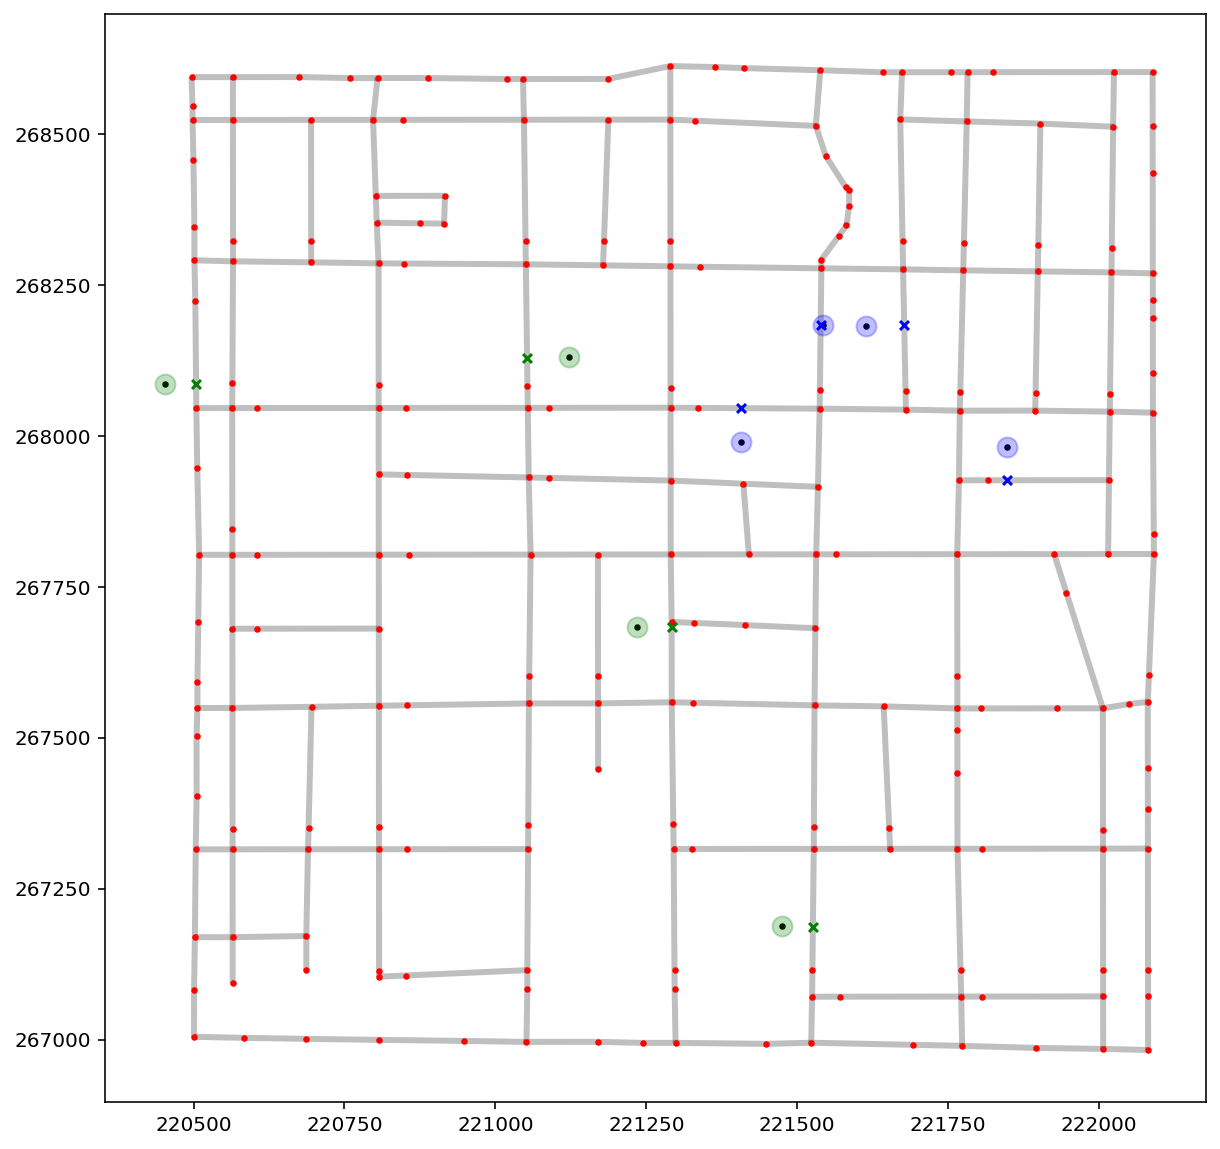

In [25]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=5, color="r", zorder=1)
schools.plot(ax=base, markersize=5, color="k", zorder=2)
pp_supply.plot(ax=base, markersize=100, alpha=0.25, color="b", zorder=3)
pp_supply_snapped.plot(ax=base, markersize=20, marker="x", color="b", zorder=3)
pp_demand.plot(ax=base, markersize=100, alpha=0.25, color="g", zorder=2)
pp_demand_snapped.plot(ax=base, markersize=20, marker="x", color="g", zorder=3);

#### Calculate distance matrix while generating shortest path trees

In [27]:
d2d_dist, tree = ntw.allneighbordistances("supply", "demand", gen_tree=True)
d2d_dist[:3, :3]

array([[ 849.03214874, 1141.07882307, 1355.96894348],
       [ 705.24686884,  997.29354317, 1212.18366358],
       [ 993.3892737 , 1052.63164495, 1500.32606844]])

In [28]:
list(tree.items())[:4], list(tree.items())[-4:]

([((0, 0), (216, 218)),
  ((0, 1), (216, 130)),
  ((0, 2), (216, 24)),
  ((0, 3), (216, 55))],
 [((3, 0), (65, 218)),
  ((3, 1), (64, 130)),
  ((3, 2), (65, 24)),
  ((3, 3), (65, 55))])

--------------------------------
### 3. The Transportation Problem
#### Create decision variables for the supply locations

In [29]:
pp_supply["dv"] = pp_supply["id"].apply(lambda _id: "S_%s" % _id)
pp_supply

,id,geometry,dv
0,0,POINT (221614.608 268182.322),S_0
1,1,POINT (221542.156 268184.287),S_1
2,2,POINT (221847.332 267982.491),S_2
3,3,POINT (221406.289 267990.060),S_3


#### Create decision variables for the demand locations

In [30]:
pp_demand["dv"] = pp_demand["id"].apply(lambda _id: "D_%s" % _id)
pp_demand

,id,geometry,dv
0,0,POINT (221121.722 268130.726),D_0
1,1,POINT (221474.120 267187.725),D_1
2,2,POINT (220452.594 268086.776),D_2
3,3,POINT (221235.286 267684.289),D_3


#### Solve the Transportation Problem

In [31]:
#trans_prob = TransportationProblem(pp_obs["dv"], d2d_dist)

####  Extract all network shortest paths

In [15]:
paths = ntw.shortest_paths(tree, "supply", "demand")
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf.head()

,id,geometry
0,"(0, 1)","LINESTRING (221652.388 266992.490, 221523.237 ..."
1,"(0, 2)","LINESTRING (221652.388 266992.490, 221523.237 ..."
2,"(0, 3)","LINESTRING (221652.388 266992.490, 221523.237 ..."
3,"(0, 4)","LINESTRING (221652.388 266992.490, 221523.237 ..."
4,"(0, 5)","LINESTRING (221652.388 266992.490, 221523.237 ..."


####  Extract the tour

In [16]:
tour = trans_prob.extract_shipments(paths_gdf, "id")
tour.head()

,id,geometry,leg
0,"(0, 1)","LINESTRING (221652.388 266992.490, 221523.237 ...",0
13,"(1, 2)","LINESTRING (220775.021 267000.303, 220807.418 ...",1
25,"(2, 3)","LINESTRING (220961.989 267315.817, 220853.037 ...",2
36,"(3, 4)","LINESTRING (220807.120 267386.436, 220806.992 ...",3
47,"(4, 6)","LINESTRING (220796.691 267553.295, 220695.386 ...",4


#### Define label helper functions and plot the.... optimal shipping schedule

In [17]:
def tour_labels(t, b):
    """Label each leg of the tour."""

    def _lab_loc(_x):
        """Helper for labeling location."""
        return _x.geometry.interpolate(0.5, normalized=True).coords[0]

    kws = {"size": 20, "ha": "center", "va": "bottom", "weight": "bold"}
    t.apply(lambda x: b.annotate(s=x.leg, xy=_lab_loc(x), **kws), axis=1)


def obs_labels(o, b):
    """Label each point pattern observation."""

    def _lab_loc(_x):
        """Helper for labeling observations."""
        return _x.geometry.coords[0]

    kws = {"size": 14, "ha": "left", "va": "bottom", "style": "oblique", "color": "k"}
    o.apply(lambda x: b.annotate(s=x.id, xy=_lab_loc(x), **kws), axis=1)

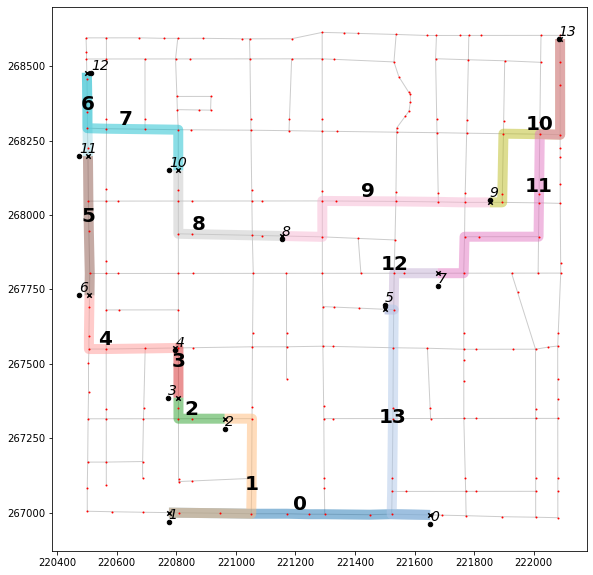

In [18]:
base = arcs.plot(alpha=0.2, linewidth=1, color="k", figsize=(10, 10), zorder=0)
tour.plot(ax=base, column="id", cmap="tab20", alpha=0.50, linewidth=10, zorder=1)
vertices.plot(ax=base, markersize=1, color="r", zorder=2)
pp_obs.plot(ax=base, markersize=20, color="k", zorder=3)
pp_obs_snapped.plot(ax=base, markersize=20, color="k", marker="x", zorder=2)
# tour leg labels
tour_labels(tour, base)
# crime scene labels
obs_labels(pp_obs, base)

----------------------